## 1. Подготовка данных
1. проверить наличие пропусков и выбросов
2. привести категориальные признаки к числовым
3. вычислить парные корреляции признаков

In [241]:
import pandas as pd

test = pd.read_csv('../datasets/insurance_train.csv')
train = pd.read_csv('../datasets/insurance_test.csv')

In [242]:
import numpy as np

print("\n1.1 Пропуски в тренировочных данных:")
print(train.isnull().sum())
print("\nПропуски в тестовых данных:")
print(test.isnull().sum())

numerical_columns = train.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = train.select_dtypes(include=['object']).columns.tolist()

print(f"\nЧисловые колонки: {numerical_columns}")
print(f"\nКатегориальные колонки: {categorical_columns}")


1.1 Пропуски в тренировочных данных:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Пропуски в тестовых данных:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Числовые колонки: ['age', 'bmi', 'children', 'charges']

Категориальные колонки: ['sex', 'smoker', 'region']


In [243]:
# Выбросы в тренировчных данных
mask = ((train[numerical_columns] - train[numerical_columns].mean()).abs() <= 3 * train[numerical_columns].std()).all(axis=1)
train = train[mask]

In [244]:
# Выбросы в тестовых данных
mask = ((test[numerical_columns] - test[numerical_columns].mean()).abs() <= 3 * test[numerical_columns].std()).all(axis=1)
test = test[mask]

Приводим категориальные признаки к числовым

In [245]:
from sklearn.calibration import LabelEncoder


print(f"Категориальные колонки: {categorical_columns}")

label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    
    combined_data = pd.concat([train[col], test[col]], axis=0)
    le.fit(combined_data)
    
    train[col] = le.transform(train[col])
    test[col] = le.transform(test[col])
    
    label_encoders[col] = le
    print(f"Колонка '{col}' закодирована: {dict(zip(le.classes_, le.transform(le.classes_)))}")

Категориальные колонки: ['sex', 'smoker', 'region']
Колонка 'sex' закодирована: {'female': np.int64(0), 'male': np.int64(1)}
Колонка 'smoker' закодирована: {'no': np.int64(0), 'yes': np.int64(1)}
Колонка 'region' закодирована: {'northeast': np.int64(0), 'northwest': np.int64(1), 'southeast': np.int64(2), 'southwest': np.int64(3)}


In [246]:
train.head()

,age,sex,bmi,children,smoker,region,charges
0,61,1,38.380,0,0,1,12950.07120
1,59,0,34.800,2,0,3,36910.60803
2,31,1,30.875,0,0,0,3857.75925
3,24,0,33.345,0,0,1,2855.43755
5,28,1,33.000,3,0,2,4449.46200


In [247]:
test.head()

,age,sex,bmi,children,smoker,region,charges
0,26,1,27.060,0,1,2,17043.34140
1,58,1,36.955,2,1,1,47496.49445
2,20,0,24.420,0,1,2,26125.67477
3,51,0,38.060,0,1,2,44400.40640
4,62,0,25.000,0,0,3,13451.12200


Вычисляем парные корреляции признаков

Матрица корреляций тренировочные данные:
               age       sex       bmi  children    smoker    region   charges
age       1.000000 -0.009687  0.121121  0.056591 -0.049819 -0.004852  0.301995
sex      -0.009687  1.000000  0.046920  0.013820  0.056154  0.021236  0.048175
bmi       0.121121  0.046920  1.000000  0.005674 -0.044051  0.141385  0.162116
children  0.056591  0.013820  0.005674  1.000000  0.037571  0.001896  0.100914
smoker   -0.049819  0.056154 -0.044051  0.037571  1.000000  0.020321  0.781237
region   -0.004852  0.021236  0.141385  0.001896  0.020321  1.000000  0.007740
charges   0.301995  0.048175  0.162116  0.100914  0.781237  0.007740  1.000000


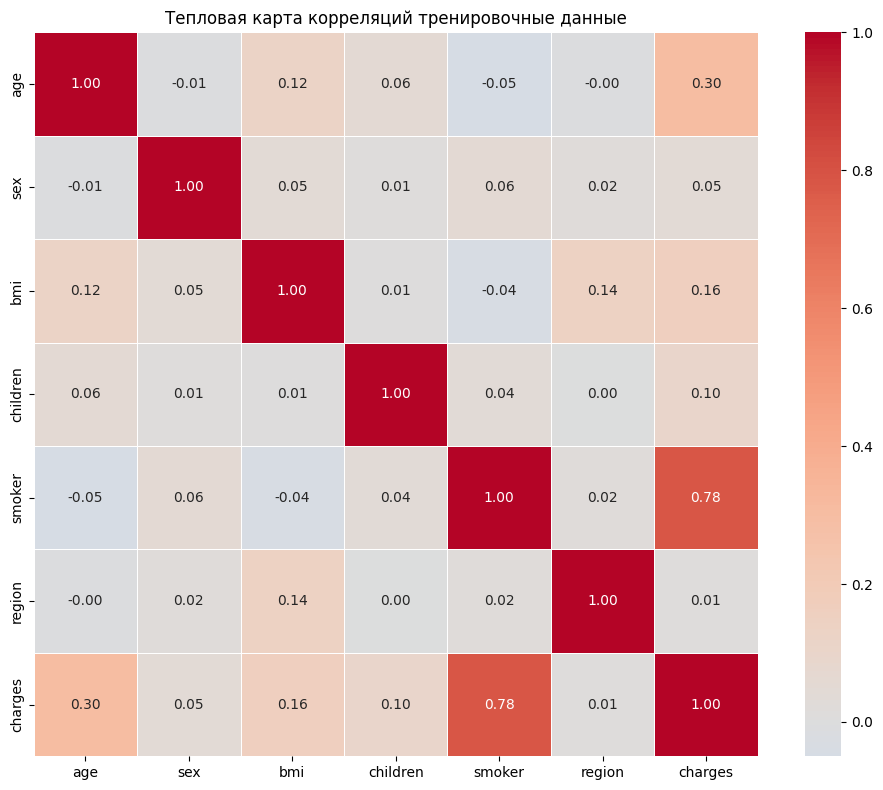

In [248]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix_train = train.corr()
print("Матрица корреляций тренировочные данные:")
print(correlation_matrix_train)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_train, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', linewidths=0.5)
plt.title('Тепловая карта корреляций тренировочные данные')
plt.tight_layout()
plt.show()

Выводы
* Высокая: Курение увеличивает стоимость страховки на 78.8%
* Средняя: Возраст влияет на стоимость страховки. Чем старше, тем дороже страховка
* Слабая: BMI имеет небольшое влияние на стоимость страховки

## 2. Многомерная линейная регрессия
Построить модель линейной регрессии и подобрать параметры:
1. аналитически (реализовать самому)
2. численно, с помощью методов градиентного спуска (реализовать самому)


Модель линейной регрессии аналитечиски обучается следующим образом:

$$
(X^TX)^{-1}X^T Y
$$

In [249]:
y_train = train['charges'].values
y_test = test['charges'].values

X_train = train.drop('charges', axis=1).to_numpy()
X_test = test.drop('charges', axis=1).to_numpy()

In [250]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_b = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]
X_test_b = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled]


Аналитическая модель

In [251]:
def analytical_solution(X, y):
    weights = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    return weights


weights_analytical = analytical_solution(X_train_b, y_train)

feature_names = ['intercept'] + list(train.drop('charges', axis=1).columns)
print("Веса модели:")
for name, weight in zip(feature_names, weights_analytical):
    print(f"  {name}: {weight:.2f}")


Веса модели:
  intercept: 12663.63
  age: 3603.45
  sex: -17.46
  bmi: 1838.74
  children: 585.19
  smoker: 9066.33
  region: -340.08


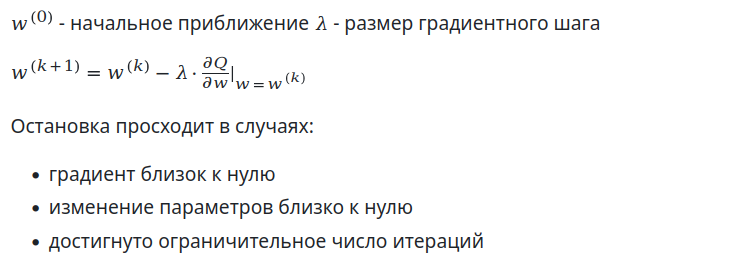

Градиент функции:

$$
\frac{1}{m}X^T × (y_{pred} - y)
$$

Веса модели:
  intercept: 12663.63
  age: 3603.45
  sex: -17.46
  bmi: 1838.74
  children: 585.19
  smoker: 9066.33
  region: -340.08


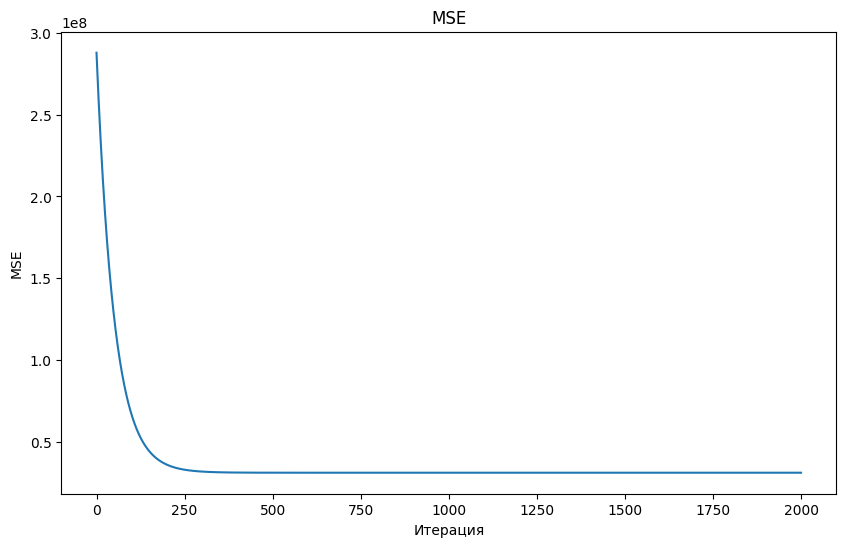

In [252]:
def gradient_descent(X, y, learning_rate=0.01, n_iter=1000, tolerance=1e-6):
    m, n = X.shape
    weights = np.random.randn(n) * 0.01
    cost_history = []
    
    for i in range(n_iter):
        y_pred = X.dot(weights)
        error = y_pred - y
        gradient = (1/m) * X.T.dot(error)
        
        weights_prev = weights.copy()
        weights = weights - learning_rate * gradient
        
        cost = np.mean(error ** 2)
        cost_history.append(cost)
        
        if np.linalg.norm(weights - weights_prev) < tolerance:
            break
    
    return weights, cost_history

n_iter=2000
weights_gd, cost_history = gradient_descent(X_train_b, y_train, 
                                          learning_rate=0.01, 
                                          n_iter=n_iter)

print("Веса модели:")
for name, weight in zip(feature_names, weights_gd):
    print(f"  {name}: {weight:.2f}")

plt.figure(figsize=(10, 6))
plt.plot(range(n_iter), cost_history)
plt.title('MSE')
plt.xlabel('Итерация')
plt.ylabel('MSE')
plt.show()


## 3. Добавление регуляризации
Модифицировать линейную модель путем добавления регуляризационного слагаемого. Найти оптимальные веса:
1. аналитически
2. численно

$$
(X^TX+\lambda I)^{−1}X^Ty
$$

In [253]:
def analytical_solution_ridge(X, y, lambda_reg=1.0):
    m, n = X.shape
    I = np.eye(n)
    I[0, 0] = 0
    
    weights = np.linalg.inv(X.T.dot(X) + lambda_reg * I).dot(X.T).dot(y)
    return weights

lambdas = [0.001, 0.01, 0.1, 1.0, 10.0]
best_lambda_analytical = None
best_mse_analytical = float('inf')
best_weights_analytical_ridge = None

print("Подбор lambda для Ridge:")
for lambda_reg in lambdas:
    weights_ridge = analytical_solution_ridge(X_train_b, y_train, lambda_reg)
    y_pred_ridge = X_test_b.dot(weights_ridge)
    mse_ridge = mean_squared_error(y_test, y_pred_ridge)
    
    print(f"  lambda = {lambda_reg:.3f}: MSE = {mse_ridge:.2f}")
    
    if mse_ridge < best_mse_analytical:
        best_mse_analytical = mse_ridge
        best_lambda_analytical = lambda_reg
        best_weights_analytical_ridge = weights_ridge

print(f"\nОптимальная lambda: {best_lambda_analytical}")

print("Веса модели:")
for name, weight in zip(feature_names, best_weights_analytical_ridge):
    print(f"  {name}: {weight:.2f}")


Подбор lambda для Ridge:
  lambda = 0.001: MSE = 41120276.72
  lambda = 0.010: MSE = 41120242.29
  lambda = 0.100: MSE = 41119899.06
  lambda = 1.000: MSE = 41116582.95
  lambda = 10.000: MSE = 41094791.83

Оптимальная lambda: 10.0
Веса модели:
  intercept: 12663.63
  age: 3564.65
  sex: -11.62
  bmi: 1819.23
  children: 584.99
  smoker: 8971.14
  region: -332.30


Градиент:

$$
\frac{1}{m} X^T(y_{pred} - y) + \frac{\lambda_{reg}}{m}w
$$

Подбор lambda для Ridge:
  lambda = 0.001: MSE = 41120276.72
  lambda = 0.010: MSE = 41120242.28
  lambda = 0.100: MSE = 41119899.06
  lambda = 1.000: MSE = 41116582.95
  lambda = 10.000: MSE = 41094791.85

Оптимальная lambda: 10.0
Веса модели:
  intercept: 12663.63
  age: 3603.45
  sex: -17.46
  bmi: 1838.74
  children: 585.19
  smoker: 9066.33
  region: -340.08


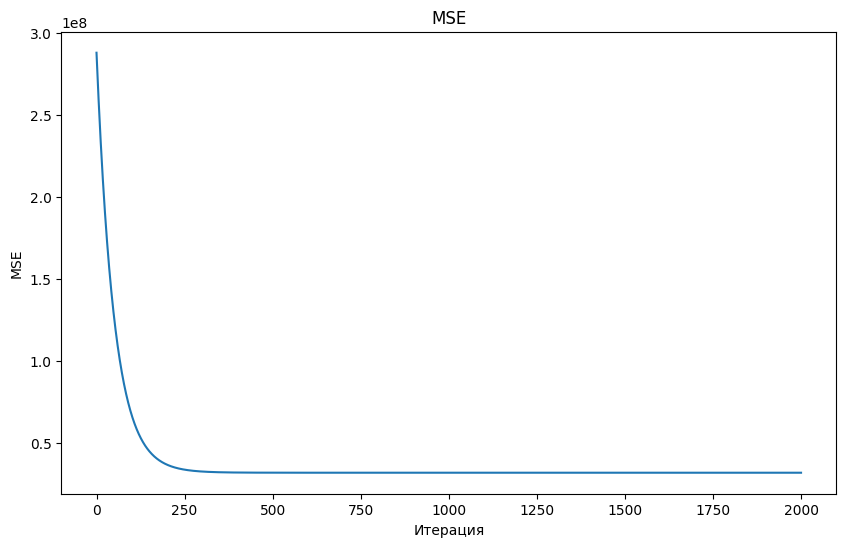

In [254]:
def gradient_descent_ridge(X, y, learning_rate=0.01, n_iter=1000, lambda_reg=1.0, verbose=True):
    m, n = X.shape
    weights = np.random.randn(n) * 0.01
    cost_history = []
    
    for i in range(n_iter):
        y_pred = X.dot(weights)
        error = y_pred - y
        
        gradient = (1/m) * X.T.dot(error)
        reg_gradient = (lambda_reg / m) * weights
        reg_gradient[0] = 0
        gradient += reg_gradient
        
        weights = weights - learning_rate * gradient
        
        cost = np.mean(error ** 2) + (lambda_reg / (2*m)) * np.sum(weights[1:]**2)
        cost_history.append(cost)
    
    return weights, cost_history

best_lambda_gd = None
best_mse_gd = float('inf')
best_weights_gd_ridge = None
best_cost_history = None

print("Подбор lambda для Ridge:")
for lambda_reg in lambdas:
    weights_ridge_gd, cost_history = gradient_descent_ridge(X_train_b, y_train, 
                                               learning_rate=0.01, 
                                               n_iter=n_iter, 
                                               lambda_reg=lambda_reg,
                                               verbose=False)
    y_pred_ridge_gd = X_test_b.dot(weights_ridge_gd)
    mse_ridge_gd = mean_squared_error(y_test, y_pred_ridge_gd)
    
    print(f"  lambda = {lambda_reg:.3f}: MSE = {mse_ridge_gd:.2f}")
    
    if mse_ridge_gd < best_mse_gd:
        best_mse_gd = mse_ridge_gd
        best_lambda_gd = lambda_reg
        best_weights_gd_ridge = weights_ridge_gd
        best_cost_history =  cost_history

print(f"\nОптимальная lambda: {best_lambda_gd}")

print("Веса модели:")
for name, weight in zip(feature_names, weights_gd):
    print(f"  {name}: {weight:.2f}")

plt.figure(figsize=(10, 6))
plt.plot(range(n_iter), best_cost_history)
plt.title('MSE')
plt.xlabel('Итерация')
plt.ylabel('MSE')
plt.show()


In [255]:
from sklearn.metrics import mean_squared_error

constant_prediction = np.mean(y_train)
y_pred_constant = np.full_like(y_test, constant_prediction)

mse_constant = mean_squared_error(y_test, y_pred_constant)

print(f"Константное предсказание: {constant_prediction:.2f}")
print(f"MSE:  {mse_constant:.2f}")

y_pred_analytical = X_test_b.dot(weights_analytical)
mse_analytical = mean_squared_error(y_test, y_pred_analytical)

print("Аналитическое решение:")
print(f"MSE:  {mse_analytical:.2f}")

y_pred_gd = X_test_b.dot(weights_gd)
mse_gd = mean_squared_error(y_test, y_pred_gd)

print("Градиентный спуск:")
print(f"MSE:  {mse_gd:.2f}")

y_pred_analytical_ridge = X_test_b.dot(best_weights_analytical_ridge)
mse_analytical_ridge = mean_squared_error(y_test, y_pred_analytical_ridge)

print(f"Аналитическое решение (Ridge, lambda={best_lambda_analytical}):")
print(f"MSE:  {mse_analytical_ridge:.2f}")

y_pred_gd_ridge = X_test_b.dot(best_weights_gd_ridge)
mse_gd_ridge = mean_squared_error(y_test, y_pred_gd_ridge)

print(f"Градиентный спуск (Ridge, lambda={best_lambda_gd}):")
print(f"MSE:  {mse_gd_ridge:.2f}")

Константное предсказание: 12663.63
MSE:  150554927.29
Аналитическое решение:
MSE:  41120280.55
Градиентный спуск:
MSE:  41120280.55
Аналитическое решение (Ridge, lambda=10.0):
MSE:  41094791.83
Градиентный спуск (Ridge, lambda=10.0):
MSE:  41094791.85
